**Before starting the Execution, make sure that the LGBM installed version supports GPU**

In [73]:
# install LGBM for GPU Training and restart the RUNTIME
import lightgbm
import numpy as np
import os
def check_LGBM_gpu_support():
    data = np.random.rand(50, 2)
    label = np.random.randint(2, size=50)
    train_data = lightgbm.Dataset(data, label=label)
    params = { 'device': 'gpu'}
    try:
        gbm = lightgbm.train(params,num_boost_round = 1, train_set=train_data)#, verbose=False
        return True
    except Exception as e:
        return False
if (not check_LGBM_gpu_support()):
    ! git clone --quiet --recursive https://github.com/Microsoft/LightGBM
    ! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;
    print('Kernel should be Restarted!')
    os._exit(0)
else:
    print('LGBM GPU version installed!')

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 36
[LightGBM] [Info] Number of data points in the train set: 50, number of used features: 2
[LightGBM] [Info] Using GPU Device: Quadro P1000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 2 dense feature groups (0.00 MB) transferred to GPU in 0.000929 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 0.380000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LGBM GPU version installed!


# **Python Modules versions**

* Numpy: 1.20.3 #np.version
* Pandas: 1.3.5 #pd.version
* SKLearn: 0.23.2 #sklearn. version
* XGB: 1.5.2 # xgb.version
* LGBM: 3.3.1 #lightgbm.version
* CatBoost: 1.0.4 #cb.version

# **0. Objective**

* The competition provides daily sales transactions, timestamped with the day of the transaction, for different items per shops.
* The training data are available for months (date_block_num) 0-33: Jan 2013 to Oct 2015
* There are supporting data for items' names and categories, as well as for shops.
* The purpose of the competition is to predict the monthly item sales per shop for the month (date_block_num) 34: Nov 2015

In [89]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import gc
from sklearn.preprocessing import LabelEncoder
from matplotlib.pylab import rcParams
from xgboost import XGBRegressor

sns.set(style="darkgrid")
sns.set(rc = {'figure.figsize':(15,8)})
aggregation_cols  = ["date_block_num", "shop_id", "item_id"]
# load data
DIR_JSON= r'E:\GitHub\Predict Future Sales\input\jsons\\'
DIR_INPUT= r'E:\GitHub\Predict Future Sales\input\\'
DIR_OUTPUT= r'E:\GitHub\Predict Future Sales\output\\'
items=pd.read_csv(DIR_INPUT+"items.csv")
shops=pd.read_csv(DIR_INPUT+"shops.csv")
cats=pd.read_csv(DIR_INPUT+"item_categories.csv")
train=pd.read_csv(DIR_INPUT+"sales_train.csv")
test=pd.read_csv(DIR_INPUT+"test.csv")

USE_SERIALIZED_MODELS=True
ENSEMBLING_METHOD = 2 # 0 for average, 1 for weighted average, 2 for stacking
START_FROM_DICT={'run_all':0,'before_feature_engineering':1,'after_train_valid_split':2,'after_mean_encoding':3}
START_FROM=0 
### For submission only, use USE_SERIALIZED_MODELS=True, START_FROM=3 and ENSEMBLING_METHOD=2

# **1. EDA**

## **1.1 Data Structure**

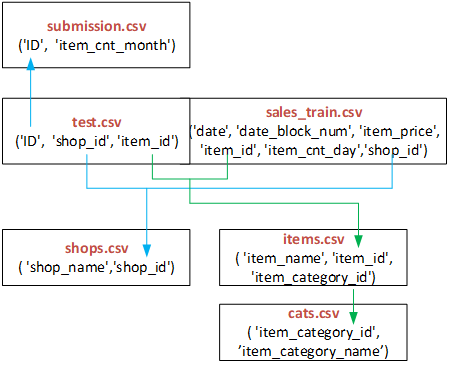

### 1.1.1 Exploring Transactions in the Training Set

In [75]:
if (START_FROM==0):
    print(train.head())

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0


In [76]:
if (START_FROM==0):
    print(train.describe())

       date_block_num       shop_id       item_id    item_price  item_cnt_day
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06
mean     1.456991e+01  3.300173e+01  1.019723e+04  8.908532e+02  1.242641e+00
std      9.422988e+00  1.622697e+01  6.324297e+03  1.729800e+03  2.618834e+00
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.200000e+01
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1.000000e+00
75%      2.300000e+01  4.700000e+01  1.568400e+04  9.990000e+02  1.000000e+00
max      3.300000e+01  5.900000e+01  2.216900e+04  3.079800e+05  2.169000e+03


In [77]:
# check if there is any NULL value
if (START_FROM==0):
    print(train.isna().any())

date              False
date_block_num    False
shop_id           False
item_id           False
item_price        False
item_cnt_day      False
dtype: bool


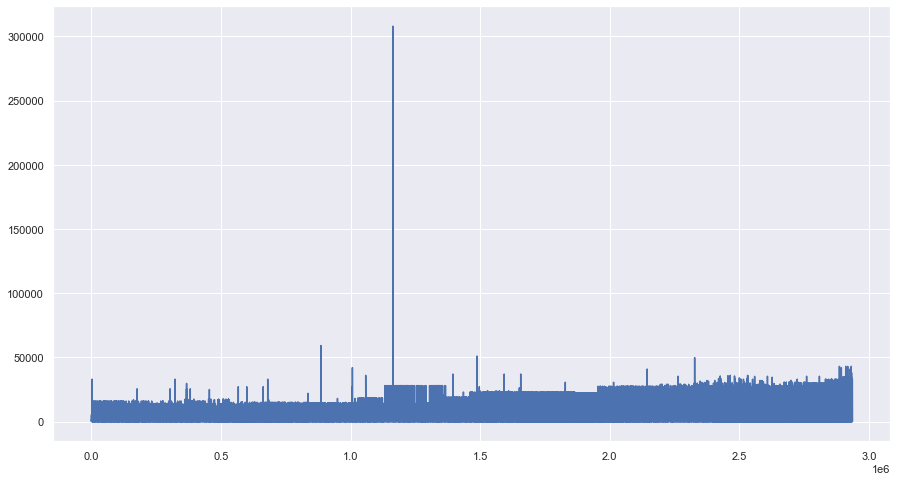

In [78]:
# Check if there are outlier values for item_price
if (START_FROM==0):
    train['item_price'].plot()

In [79]:
# check how many transactions are above the outlier tresholds: 0 and 50,000
if (START_FROM==0):
    print(train[train['item_price']>50000]['item_id'].unique(),train[train['item_price']>50000]['item_id'].count(),train[train['item_price']<0]['item_id'].count())
    #train[train['item_id']==6674]

[11365  6066 13199] 3 1


In [80]:
# Check for items with a small number of transactions
if (START_FROM==0):
    item_transaction_count=train.groupby(['item_id'])['date'].count()
    print(item_transaction_count[item_transaction_count<10].value_counts())

1    2371
2    1054
3     669
4     540
5     470
6     436
8     368
7     346
9     287
Name: date, dtype: int64


In [81]:
# Check how many of the items with small number of transactions didn't sale for the last year
if (START_FROM==0):
    item_max_date_block=train.groupby(["item_id"])["date_block_num"].max()
    item_min_date_block=train.groupby(["item_id"])["date_block_num"].min()
    item_nb_transactions_last_date_block=pd.concat([item_transaction_count,item_max_date_block,item_min_date_block],axis=1)
    item_nb_transactions_last_date_block.columns=['nbr_transactions','last_sale','first_sale']
    item_nb_transactions_last_date_block['diff_first_last']=item_nb_transactions_last_date_block['last_sale']-item_nb_transactions_last_date_block['first_sale']
    #item_nb_transactions_last_date_block['diff_first_last'].value_counts().sort_index() #sort_values()
    print(item_nb_transactions_last_date_block[(item_nb_transactions_last_date_block['nbr_transactions']<10) & (item_nb_transactions_last_date_block['last_sale']<22)])

         nbr_transactions  last_sale  first_sale  diff_first_last
item_id                                                          
0                       1         20          20                0
1                       6         21          15                6
3                       2         19          18                1
4                       1         20          20                0
6                       1         18          18                0
...                   ...        ...         ...              ...
22157                   4          8           1                7
22161                   1          4           4                0
22165                   2         16           7                9
22168                   6          8           0                8
22169                   1         14          14                0

[4156 rows x 4 columns]


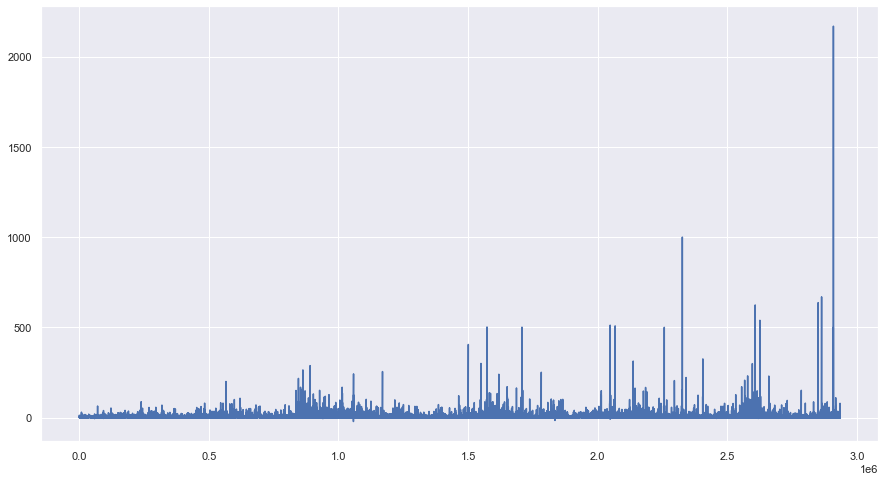

In [82]:
# Check if there are outlier values for item_cnt_day
if (START_FROM==0):
    train['item_cnt_day'].plot()

In [83]:
# Check the number of transactions outside the 0-750 thresholds and how many items had 'returns'
if (START_FROM==0):
    print(len(train[train['item_cnt_day']<0]['item_id'].unique()),train[train['item_cnt_day']<0]['item_id'].count(),train[train['item_cnt_day']>750]['item_id'].count())

3511 7356 2


* Summary for the training transactions
    - 2,935,849 Transactions
    - No NULL/Missing values
    - Item Prices from -1 to 307,980 [negative price does't make sense] We can consider prices below 0 and above 50,000 RUB as outliers.
          # 1 US is around 60 RUB in late 2014
    - item_cnt_day from -22 to 2169 [negative value indicates item return]
          # There many items with a small number (<10) of transactions. If these items were discontinued for at least one year, it's better to remove their transactions.
          # There are 7356 transactions for 'Return Items' and 2 tarnsaction with more than 750 item_cnt. They should be removed as they are singular transactions. Moreover, the return transactions are spread over 3511 items. That means that they are not a specific phenomena for a group of items and their number is small compared to the total number of transactions.

### **1.1.2 Exploring SHOP dataset**

In [84]:
if (START_FROM==0):
    print(shops)

                                          shop_name  shop_id
0                     !Якутск Орджоникидзе, 56 фран        0
1                     !Якутск ТЦ "Центральный" фран        1
2                                  Адыгея ТЦ "Мега"        2
3                    Балашиха ТРК "Октябрь-Киномир"        3
4                          Волжский ТЦ "Волга Молл"        4
5                            Вологда ТРЦ "Мармелад"        5
6                        Воронеж (Плехановская, 13)        6
7                            Воронеж ТРЦ "Максимир"        7
8                      Воронеж ТРЦ Сити-Парк "Град"        8
9                                 Выездная Торговля        9
10                       Жуковский ул. Чкалова 39м?       10
11                       Жуковский ул. Чкалова 39м²       11
12                              Интернет-магазин ЧС       12
13                              Казань ТЦ "Бехетле"       13
14                          Казань ТЦ "ПаркХаус" II       14
15                      

* The 'shops' data has the shop_id and shop_name and there are 60 shops
* The shop_name is a string which has three parts 'city'+'location_type'+'specific_address' (I got the idea from the discussions and others' Kernels and I have checked using Google map and Google Translation)
      - For easy string processing, we need to have these three parts 'space-separated'
      - Shop 46: needs to be adjusted to avoid the space between its composed name 'Сергиев Посад'
* We can see that there are dupplicated shop names:
      - Shop 0 '!Якутск Орджоникидзе, 56 фран' with shop 57 'Якутск Орджоникидзе, 56'
      - Shop 1 '!Якутск ТЦ "Центральный" фран' with shop 58 'Якутск ТЦ "Центральный"'
      - shop 10 'Жуковский ул. Чкалова 39м?' with shop 11 'Жуковский ул. Чкалова 39м²'
      - shop 40 'РостовНаДону ТРК "Мегацентр Горизонт"' with shop 39 'РостовНаДону ТРК "Мегацентр Горизонт"'
* The location types are {'МТРЦ','ТК','ТРК','ТРЦ','ТЦ'}
* The online stores:
       - shop 11 'Интернет-магазин' : Online Strore
       - shop 55 'Цифровой склад': Digital Warehouse

### **1.1.3 Exploring Item Category Data (cats)**

In [85]:
if (START_FROM==0):
    print(cats.shape)
    print(cats.head(20))

(84, 2)
            item_category_name  item_category_id
0      PC - Гарнитуры/Наушники                 0
1             Аксессуары - PS2                 1
2             Аксессуары - PS3                 2
3             Аксессуары - PS4                 3
4             Аксессуары - PSP                 4
5          Аксессуары - PSVita                 5
6        Аксессуары - XBOX 360                 6
7        Аксессуары - XBOX ONE                 7
8               Билеты (Цифра)                 8
9              Доставка товара                 9
10       Игровые консоли - PS2                10
11       Игровые консоли - PS3                11
12       Игровые консоли - PS4                12
13       Игровые консоли - PSP                13
14    Игровые консоли - PSVita                14
15  Игровые консоли - XBOX 360                15
16  Игровые консоли - XBOX ONE                16
17    Игровые консоли - Прочие                17
18                  Игры - PS2                18
19          

In [86]:
if (START_FROM==0):
    cats_type_code= cats.item_category_name.apply( lambda x: x.split(" ")[0] ).astype(str)
    print(cats_type_code.value_counts())
# Игровые = Gaming, Игры = Games, Аксессуары = Accessories (but in here they are all linked to Gaming consoles)
#cats[cats['item_category_name'].str.contains('Аксессуары')]

Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Служебные      2
Чистые         2
PC             1
Билеты         1
Доставка       1
Элементы       1
Name: item_category_name, dtype: int64


* The item category name has two elements separated by 'space'
    - The 'space' separation provides the category sub-type (Games, Books,.....). We should consider the groups which have 5+ categories. We need also to group 'Games','Gaming' and 'Accessories' together in 'Games' group and use it as category type.
    - Subtype2 can be defined based on PC, Android, XBOX, PS, MAC split.

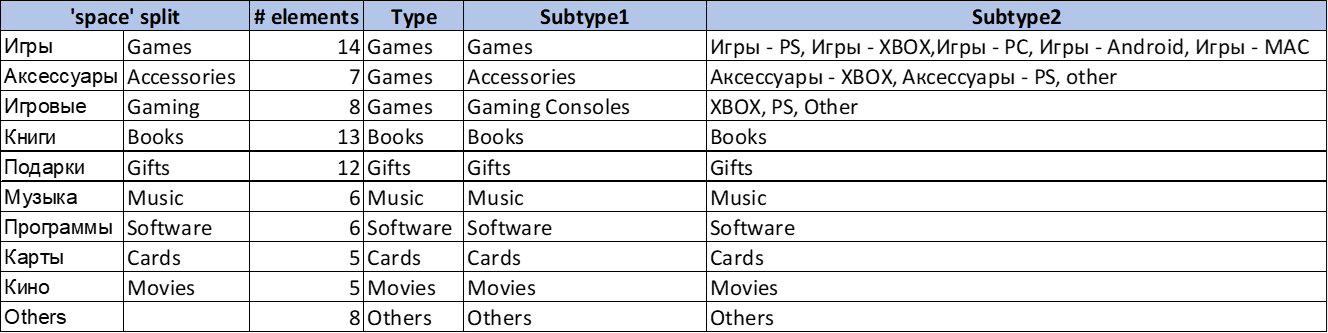

### **1.1.4 Exploring Items data**

In [87]:
if (START_FROM==0):
    print(items.head(20))
    print(items.shape)

                                            item_name  item_id  \
0           ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1   !ABBYY FineReader 12 Professional Edition Full...        1   
2       ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3     ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4         ***КОРОБКА (СТЕКЛО)                       D        4   
5   ***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ  (UNI)         ...        5   
6            ***УДАР ПО ВОРОТАМ (UNI)               D        6   
7          ***УДАР ПО ВОРОТАМ-2 (UNI)               D        7   
8            ***ЧАЙ С МУССОЛИНИ                     D        8   
9       ***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI)             D        9   
10          *ЗА ГРАНЬЮ СМЕРТИ                       D       10   
11          *ЛИНИЯ СМЕРТИ                           D       11   
12                    *МИХЕЙ И ДЖУМАНДЖИ  Сука любовь       12   
13          *СПАСАЯ ЭМИЛИ                           D       13   
14        

* The Items dataframe includes the item_id, item_category_id and item_name.
* To get features from the text we need to use NLP feature extraction techniques

# **2. Data Visualization**

## **2.1 Pivot Table for item_cnt_month by shop and month** (aggregated items)

In [90]:
if (START_FROM==0):
    df = train[['date_block_num','shop_id','item_id','item_cnt_day']]
    pivot_cnt_month_per_shop = pd.pivot_table(data=df,index=['date_block_num'],columns=['shop_id'],fill_value=0,values='item_cnt_day',aggfunc="sum")
    pivot_cnt_month_per_shop.reset_index(drop=True,inplace=True)
    pivot_cnt_month_per_shop.columns.name = None
    pivot_cnt_month_per_shop.to_csv(DIR_OUTPUT + 'pivot_date_shops.csv',index=False) # Explore the table using MS Excel
    print(pivot_cnt_month_per_shop)

      0     1     2     3     4     5     6     7     8     9   ...    50  \
0   5578  2947  1146   767  2114     0  3686  2495  1463     0  ...  3406   
1   6127  3364   488   798  2025   877  4007  2513  1156     0  ...  3054   
2      0     0   753   959  2060  1355  4519  2460   977     0  ...  3610   
3      0     0   583   647   285  1008  3168  1540    -1     0  ...  2740   
4      0     0   553   710  1211  1110  3022  1647     0     0  ...  2839   
5      0     0   832   784  1464  1393  3847  2085     0     0  ...  3761   
6      0     0   807   721  1378  1265  3360  2031     0     0  ...  3235   
7      0     0   875   890  1713  1510  3702  2397     0     0  ...  3718   
8      0     0   945  1026  1536  1298  4208  2599     0     0  ...  3655   
9      0     0   795   793  1482  1267  3675  2236     0  6526  ...  3525   
10     0     0   862   970  1486  1390  3938  2452     0     0  ...  3554   
11     0     0  1322  1134  2248  2223  5467  3731     0     0  ...  4762   

<Figure size 1080x576 with 0 Axes>

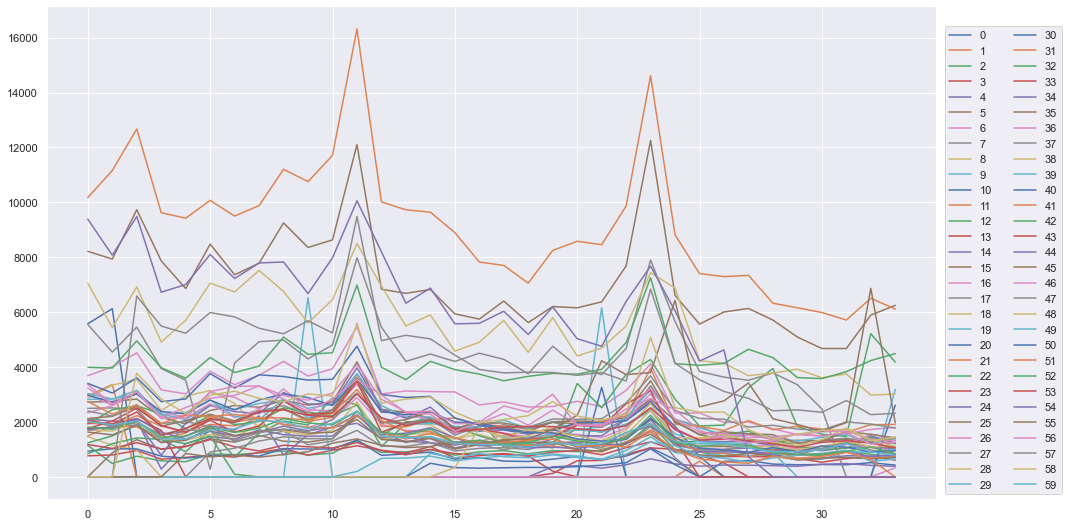

In [91]:
# Plotting the Pivot table
if (START_FROM==0):
    plt.figure()
    ax=pivot_cnt_month_per_shop.plot()
    ax.legend(loc=(1.01, 0.01), ncol=2)
    plt.tight_layout()

* The analysis of the Pivot Table is better done in MS Excel to navigate easily through the table
    * You can confirm that shops 0,1 and 10 records complement shops 57,58 and 11 respectively
    * Shop 40 looks operating in parallel with shop 39 and droping after 11 months (they have the same name!!)
    * Shops 8,9,20,23 have sporadic sales (looks noise). It's better to be removed from the training set.
    * Shop 32 has only old records. It's better to remove them.
* From the plot, we can see that item sales are peaking in December and they have a slight downward trend.

In [92]:
# Check the shops which are in the Public Test Dataset
if (START_FROM==0):
    print(np.sort(test['shop_id'].unique()))
    # The noisy shops are not included in the Test dataset
    # The shop 32 is not in the test dataset

[ 2  3  4  5  6  7 10 12 14 15 16 18 19 21 22 24 25 26 28 31 34 35 36 37
 38 39 41 42 44 45 46 47 48 49 50 52 53 55 56 57 58 59]


<Figure size 1080x576 with 0 Axes>

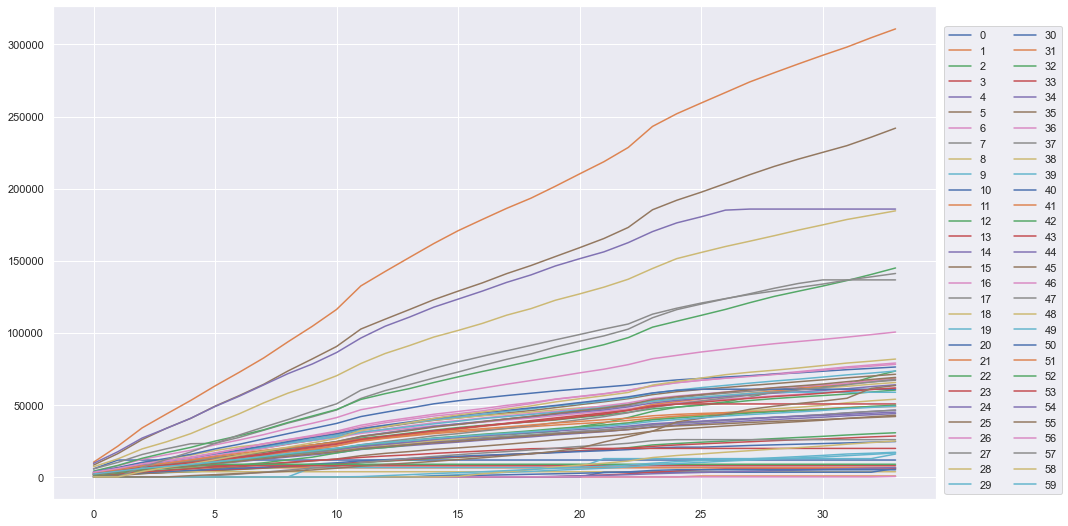

In [93]:
# Cumulative sales per month per shop
if (START_FROM==0):
    df = pivot_cnt_month_per_shop.cumsum()
    plt.figure()
    ax=df.plot()
    ax.legend(loc=(1.01, 0.01), ncol=2)
    plt.tight_layout()

In [94]:
# shops with more than 100,000 item sold (cumulative since thier opening)
if (START_FROM==0):
    last_sum=df.iloc[33]
    print(last_sum[last_sum>100000])

6     100489
25    241920
27    136657
28    184557
31    310777
42    144934
54    185790
57    141107
Name: 33, dtype: int64


## **2.2 Visualizing Revenues per date_block/Shop**

<Figure size 1080x576 with 0 Axes>

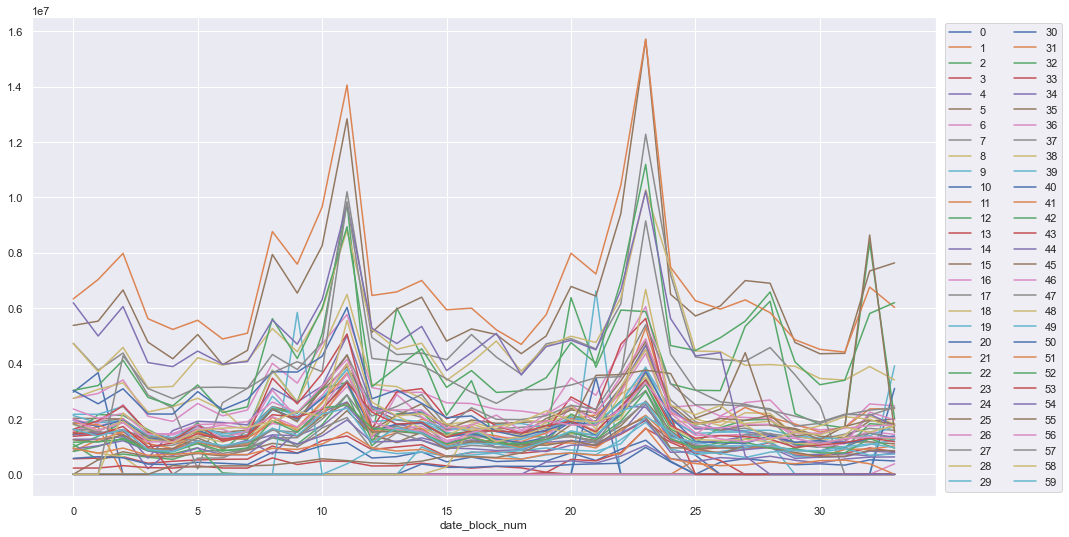

In [95]:
if (START_FROM==0):
    train['revenue']=train['item_price']*train['item_cnt_day']
    pivot_revenue_month_per_shop=pd.pivot_table(train, values='revenue', index=['date_block_num'], columns=['shop_id'], aggfunc=np.sum,fill_value=0)
    plt.figure()
    ax=pivot_revenue_month_per_shop.plot()
    ax.legend(loc=(1.01, 0.01), ncol=2)
    plt.tight_layout()

# **3. Data Cleaning**

## **3.1 Cleaning based on the transactions**

In [96]:
# Remove outliers
if (START_FROM==0):
    train = train[(train['item_price'] < 50000 )& (train['item_cnt_day'] < 1000) & (train['item_price'] > 0)]
    # Remiving the transactions for items with less than 10 transactions ant the last transaction is at least 1-year old
    item_transaction_count=train.groupby(['item_id'])['date'].count()
    item_max_date_block=train.groupby(["item_id"])["date_block_num"].max()
    item_nb_transactions_last_date_block=pd.concat([item_transaction_count,item_max_date_block],axis=1)
    item_nb_transactions_last_date_block.columns=['nbr_transactions','last_sale']
    items_to_drop=item_nb_transactions_last_date_block[(item_nb_transactions_last_date_block['nbr_transactions']<10) & (item_nb_transactions_last_date_block['last_sale']<22)]
    print('Shapes before the drop: ',train.shape,items.shape,items_to_drop.shape)
    train=train[~train['item_id'].isin(list(items_to_drop.index))]
    print('Shapes after the drop: ',train.shape)

Shapes before the drop:  (2935843, 7) (22170, 3) (4154, 2)
Shapes after the drop:  (2923256, 7)


## **3.2 Cleaning based on the Shops exploration**

In [97]:
if (START_FROM==0):
    train['shop_id']=train['shop_id'].replace({0:57,1:58,11:10,40:39}) #,,23:34
    train=train[~train['shop_id'].isin([8,9,20,23,32])]
    test['shop_id']=test['shop_id'].replace({0:57,1:58,11:10,40:39})
    # We can try to remove the shops which are not included in the test dataset
    # We may have new shops appearing in the Private Test dataset. In the recent competitions, the public test dataset is not known.
    #train=train.loc[train['shop_id'].isin(test['shop_id'].unique()),:] 
    train.reset_index(drop = True,inplace=True)
    #test.reset_index(drop = True,inplace=True)
    print('Shapes after the drop: ',train.shape)

Shapes after the drop:  (2899934, 7)


# **4. Auxilary Data Feature Encoding**

## **4.1 SHOP Data**

In [98]:
# Clean up some shop names and add 'city' and 'category' to shops df.
if (START_FROM==0):
    shops.loc[ shops['shop_name'] == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
    shops["city"] = shops['shop_name'].str.split(" ").map( lambda x: x[0] )
    shops.loc[shops.city == "!Якутск", "city"] = "Якутск"
    shops["shop_city"] = LabelEncoder().fit_transform( shops["city"] )

    shops["category"] = shops['shop_name'].str.split(" ").map( lambda x: x[1] )
    shop_location_dict={'ТК':1,'ТЦ':4,'ТРК':2,'ТРЦ':3,'МТРЦ':0}
    shops['shop_category'] = shops['category'].apply( lambda x: shop_location_dict[x] if x in shop_location_dict else 0 )

    shops = shops[["shop_id", "shop_category", "shop_city"]]

## **4.2 Item Category Feature Encoding**

In [99]:
# Cleaning Item Category Data
if (START_FROM==0):
    cats["sub_type_code1"] = cats.item_category_name.apply( lambda x: x.split(" ")[0] ).astype(str)
    #cats.loc[ (cats.type_code == "Игровые")| (cats.type_code == "Аксессуары"), "category" ] = "Игры"
    category = []
    for cat in cats["sub_type_code1"].unique():
        if len(cats[cats["sub_type_code1"] == cat]) >= 5: 
            category.append( cat )
    cats["sub_type_code1"] = cats["sub_type_code1"].apply(lambda x: x if (x in category) else "others")
    cats["type_code"] = cats["sub_type_code1"]
    cats["sub_type_code2"] = cats["sub_type_code1"]
    cats.loc[ (cats["sub_type_code1"] == "Игровые")| (cats["sub_type_code1"] == "Аксессуары"), "type_code" ] = "Игры"
    cats.loc[cats['sub_type_code1']=='Игры','sub_type_code2']=cats['item_category_name'].str[:8]
    cats.loc[cats['sub_type_code1']=='Аксессуары','sub_type_code2']=cats['item_category_name'].str[:15]
    cats.loc[cats['sub_type_code1']=='Игровые','sub_type_code2']=cats['item_category_name'].str[:20]
    print(cats)

           item_category_name  item_category_id sub_type_code1 type_code  \
0     PC - Гарнитуры/Наушники                 0         others    others   
1            Аксессуары - PS2                 1     Аксессуары      Игры   
2            Аксессуары - PS3                 2     Аксессуары      Игры   
3            Аксессуары - PS4                 3     Аксессуары      Игры   
4            Аксессуары - PSP                 4     Аксессуары      Игры   
..                        ...               ...            ...       ...   
79                  Служебные                79         others    others   
80         Служебные - Билеты                80         others    others   
81    Чистые носители (шпиль)                81         others    others   
82  Чистые носители (штучные)                82         others    others   
83           Элементы питания                83         others    others   

     sub_type_code2  
0            others  
1   Аксессуары - PS  
2   Аксессуары - PS  

In [100]:
# Label Encoding
if (START_FROM==0):
    cats["type_code"] = LabelEncoder().fit_transform(cats["type_code"])
    cats["sub_type_code1"] = LabelEncoder().fit_transform(cats["sub_type_code1"])
    cats["sub_type_code2"] = LabelEncoder().fit_transform(cats["sub_type_code2"])
    # Removing the name and leaving numerical values only 
    cats = cats[["item_category_id", "sub_type_code1","sub_type_code2", "type_code"]]

## **4.3 Item Features**

* We create the Item features using TFIDF vectorization and we use PCA for dimensionality reduction.
* We use Spacy tokenizer with the Russian language corpus
* 'English Stop words' worked better than 'Russian Stop words'. Most likely because the text is based on Technical words.
* We use PCA with 6 components. It's a Hyperparameter to tune. I tried 2,4,6 and 8. 6 worked best for me. 

In [101]:
if (START_FROM==0):
    import spacy
    #!python -m spacy download ru_core_news_md #ru_core_news_sm ru_core_news_lg
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.decomposition import PCA
    #russian_stopwords = open('../input/russian-stop-words/stopwords-ru.txt', 'r').read().splitlines()

    def preprocess_items(items,nb_components=4):
        class LemmaTokenizer(object):
            def __init__(self):
                self.spacynlp = spacy.load('ru_core_news_md') #Lighter version is ru_core_news_md (40 Mbytes vs. 490 MBytes--ru_core_news_lg) 
            def __call__(self, doc):
                nlpdoc = self.spacynlp(doc)
                #nlpdoc = [token.lemma_.strip() for token in nlpdoc if ((len(token.lemma_.strip()) > 1) and (token.lemma_.strip().isalpha())) ]
                nlpdoc = [token.lemma_.strip() for token in nlpdoc if ((len(token.lemma_.strip()) > 1) or (token.lemma_.strip().isalnum())) ]
                return nlpdoc

        vect = TfidfVectorizer(tokenizer=LemmaTokenizer(),stop_words='english')
        features=vect.fit_transform(items['item_name'])
        pca = PCA(n_components=nb_components, random_state=999)
        reduced_features = pca.fit_transform(features.toarray())
        for i in range(nb_components):
            items['items_pca'+str(i)]=reduced_features[:,i]
        return items.drop('item_name',axis=1)
    items_nb_components=6
    if items_nb_components!=0:
        items=preprocess_items(items,items_nb_components)
    else:
        items.drop('item_name',axis=1,inplace=True)

In [102]:
items.head()

,item_id,item_category_id,items_pca0,items_pca1,items_pca2,items_pca3,items_pca4,items_pca5
0,0,40,-0.036758,0.004868,-0.011702,-0.023439,-0.023877,-0.008259
1,1,76,0.269713,-0.131576,-0.009960,0.032038,-0.076289,-0.027797
2,2,40,-0.040803,-0.005712,-0.011671,-0.019841,-0.011238,0.002669
3,3,40,-0.037959,0.004585,-0.012238,-0.024354,-0.024408,-0.010230
4,4,40,-0.036986,0.004847,-0.012747,-0.024931,-0.027743,-0.008545


# **5. Building the Training/Validation/Test Datasets**

## **5.1 Building the preprocessing matrix (train and test combination for Item/Shop/dateblock)**

In [103]:
# Preprocessing create a matrix df with every combination of month, shop and item in order of increasing month. Item_cnt_day is summed into an item_cnt_month.
if (START_FROM==0):
    from itertools import product
    matrix = []

    for i in range(34):
        sales = train[train.date_block_num == i]
        matrix.append( np.array(list( product( [i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype = np.int16) )

    matrix = pd.DataFrame( np.vstack(matrix), columns = aggregation_cols )
    matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
    matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
    matrix["item_id"] = matrix["item_id"].astype(np.int16)
    matrix.sort_values( aggregation_cols, inplace = True )

    # add revenue to train df
    group = train.groupby(aggregation_cols).agg( {"item_cnt_day": ["sum"]} )
    group.columns = ["item_cnt_month"]
    group.reset_index( inplace = True)
    matrix = pd.merge( matrix, group, on = aggregation_cols, how = "left" )
    matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).astype(np.float16)

    # Create a test set for month 34.
    test["date_block_num"] = 34
    test["date_block_num"] = test["date_block_num"].astype(np.int8)
    test["shop_id"] = test.shop_id.astype(np.int8)
    test["item_id"] = test.item_id.astype(np.int16)

    # Concatenate train and test sets.
    matrix = pd.concat([matrix, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=aggregation_cols)
    matrix.fillna( 0, inplace = True )

    # Add shop, items and categories data onto matrix df.
    matrix = pd.merge( matrix, shops, on = ["shop_id"], how = "left" )
    matrix = pd.merge(matrix, items, on = ["item_id"], how = "left")
    matrix = pd.merge( matrix, cats, on = ["item_category_id"], how = "left" )
    matrix["shop_city"] = matrix["shop_city"].astype(np.int8)
    matrix["shop_category"] = matrix["shop_category"].astype(np.int8)
    matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
    matrix["sub_type_code1"] = matrix["sub_type_code1"].astype(np.int8)
    matrix["sub_type_code2"] = matrix["sub_type_code2"].astype(np.int8)
    matrix["type_code"] = matrix["type_code"].astype(np.int8)
    for i in range(items_nb_components):
        matrix['items_pca'+str(i)]=matrix['items_pca'+str(i)].astype(np.float16)

In [104]:
if (START_FROM==0):
    pickle.dump( matrix, open( DIR_OUTPUT + "matrix_00_init_10Feb.pkl", "wb" ) )
    print('Before Feature Engineering Executed!!')
else: 
    print('Jumped to Feature Engineering START_FROM>0')
if (START_FROM==1):
    matrix=pickle.load(open( DIR_OUTPUT+"matrix_00_init_10Feb.pkl", "rb" ) )

Before Feature Engineering Executed!!


## **5.2 Feature Enginnering I- Adding Lag-based features**

In [105]:
# Define a lag feature function
def lag_feature( df,lags, cols ):
    for col in cols:
        tmp = df[aggregation_cols+[col]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = aggregation_cols+[ col + "_lag_"+str(i)]
            shifted['date_block_num'] = shifted['date_block_num'] + i
            df = pd.merge(df, shifted, on=aggregation_cols, how='left')
    return df

def add_feature_using_lag(src_df,dest_df,feature_name,groupby_list,aggregate_item,aggregate_func_list,lag_list,with_drop=True,np_type=np.float16):
    group = src_df.groupby(groupby_list ).agg({aggregate_item :aggregate_func_list})
    group.columns = [feature_name]
    group.reset_index(inplace = True)
    dest_df = dest_df.merge(group, on = groupby_list, how = "left")
    dest_df[feature_name] = dest_df[feature_name].astype(np_type)
    if lag_list!=0: dest_df = lag_feature( dest_df, lag_list, [feature_name] )
    if with_drop: dest_df.drop( [feature_name], axis = 1, inplace = True )
    return dest_df


### **5.2.1 item_cnt_month lag features for different combinations**

In [106]:
# Feature Engineering, add lag features to matrix df.
if (START_FROM<2):
    print('1- Adding item_cnt_month lag features.') 
    matrix = lag_feature( matrix, [1,2,3], ["item_cnt_month"] )
    print('2- Adding the previous month average item_cnt.')
    matrix =add_feature_using_lag(matrix,matrix,"date_avg_item_cnt",["date_block_num"],"item_cnt_month",["mean"],[1])
    print('3- Adding lag values of item_cnt_month for month / item_id.')
    matrix =add_feature_using_lag(matrix,matrix,'date_item_avg_item_cnt',['date_block_num', 'item_id'],"item_cnt_month",["mean"],[1,2,3])
    print('4- Adding lag values for item_cnt_month for every month / shop combination.')
    matrix =add_feature_using_lag(matrix,matrix,'date_shop_avg_item_cnt',["date_block_num","shop_id"],"item_cnt_month",["mean"],[1,2,3])
    print('5- Adding lag values for item_cnt_month for month/shop/item.')
    matrix =add_feature_using_lag(matrix,matrix,'date_shop_item_avg_item_cnt', ["date_block_num","shop_id","item_id"],"item_cnt_month",["mean"],[1,2,3])
    print('6- Adding lag values for item_cnt_month for month/shop/item subtype1.')
    matrix =add_feature_using_lag(matrix,matrix,'date_shop_subtype1_avg_item_cnt', ['date_block_num', 'shop_id', 'sub_type_code1'],"item_cnt_month",["mean"],[1])
    print('7- Adding lag values for item_cnt_month for month/shop/item subtype2.')
    matrix =add_feature_using_lag(matrix,matrix,'date_shop_subtype2_avg_item_cnt', ['date_block_num', 'shop_id', 'sub_type_code2'],"item_cnt_month",["mean"],[1])
    print('8- Adding lag values for item_cnt_month for month/city.')
    matrix =add_feature_using_lag(matrix,matrix,'date_city_avg_item_cnt', ['date_block_num', 'shop_city'],"item_cnt_month",["mean"],[1])
    print('9- Adding lag values for item_cnt_month for month/city/item.')
    matrix =add_feature_using_lag(matrix,matrix,'date_item_city_avg_item_cnt', ['date_block_num', 'item_id', 'shop_city'],"item_cnt_month",["mean"],[1])

1- Adding item_cnt_month lag features.
2- Adding the previous month average item_cnt.
3- Adding lag values of item_cnt_month for month / item_id.
4- Adding lag values for item_cnt_month for every month / shop combination.
5- Adding lag values for item_cnt_month for month/shop/item.
6- Adding lag values for item_cnt_month for month/shop/item subtype1.
7- Adding lag values for item_cnt_month for month/shop/item subtype2.
8- Adding lag values for item_cnt_month for month/city.
9- Adding lag values for item_cnt_month for month/city/item.


### **5.2.2 Item Price-based lag features**

In [107]:
if (START_FROM<2):
    print('1- Adding average item price') 
    matrix =add_feature_using_lag(train,matrix,'item_avg_item_price',["item_id"],"item_price",["mean"],[],with_drop=False)
    print('2- Adding item price average per month')
    matrix =add_feature_using_lag(train,matrix,'date_item_avg_item_price',["date_block_num","item_id"],
                                  "item_price",["mean"],[1,2,3],with_drop=False)

    # Add delta price values - how current month average pirce relates to global average.
    print('3- Adding avg item price per month change over previous months (lag values)')
    lags = [1, 2, 3]
    for i in lags:
        matrix["delta_price_lag_" + str(i) ] = (matrix["date_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]

    def select_trends(row) :
        for i in lags:
            if row["delta_price_lag_" + str(i)]:
                return row["delta_price_lag_" + str(i)]
        return 0

    matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
    matrix["delta_price_lag"] = matrix['delta_price_lag'].astype( np.float16 )
    matrix["delta_price_lag"].fillna( 0 ,inplace = True)

    features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
    for i in lags:
        features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
        features_to_drop.append("delta_price_lag_" + str(i) )
    matrix.drop(features_to_drop, axis = 1, inplace = True)

1- Adding average item price
2- Adding item price average per month
3- Adding avg item price per month change over previous months (lag values)


### **5.2.3 Revenue-based Features**

In [108]:
if (START_FROM<2):
    train["revenue"] = train["item_cnt_day"] * train["item_price"]
    print('1- Adding total shop revenue per month.')
    matrix =add_feature_using_lag(train,matrix,'date_shop_revenue', 
                 ["date_block_num","shop_id"],"revenue",["sum"],[],with_drop=False,np_type=np.float32)
    matrix =add_feature_using_lag(matrix,matrix,'shop_avg_revenue', 
                 ["shop_id"],"date_shop_revenue",["mean"],[],with_drop=False,np_type=np.float32)
    # Add lag values of revenue per month.
    # Add delta revenue values - how current month revenue relates to global average.

    matrix["delta_revenue"] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
    matrix["delta_revenue"] = matrix["delta_revenue"]. astype(np.float32)

    matrix = lag_feature(matrix, [1], ["delta_revenue"])
    matrix["delta_revenue_lag_1"] = matrix["delta_revenue_lag_1"].astype(np.float32)
    matrix.drop( ["date_shop_revenue", "shop_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)

1- Adding total shop revenue per month.


## **5.3 Feature Engineering II- Other features**

In [109]:
if (START_FROM<2):
    def nb_business_days(y,m):
        current_month=str(y)+'-'+('0' if m<10 else '')+str(m)
        if m==12:
            y+=1
            m=1
        else:
            m+=1
        next_month=str(y)+'-'+('0' if m<10 else '')+str(m)
        return np.busday_count(current_month, next_month)

    # Add month and number of days in each month to matrix df.
    matrix["month"] = matrix["date_block_num"] % 12
    matrix['year']  =matrix['date_block_num']//12
    days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
    matrix["days"] = matrix["month"].map(days).astype(np.int8)
    matrix['year']=matrix['year'].astype('int8')
    # Add month's number of business days and weekends
    tmp_series=pd.Series(np.linspace(0,34,35),dtype=np.int8)
    nb_business_days_arr=tmp_series.apply(lambda x: nb_business_days(x//12+2012, x%12+1)) 
    matrix['nb_business_days']=matrix['date_block_num'].map(nb_business_days_arr).astype(np.int8)
    matrix['nb_holiday_days']=matrix["days"]-matrix['nb_business_days']
    matrix['nb_holiday_days']=matrix['nb_holiday_days'].astype(np.int8)
    # Add the month of each shop and item first sale.
    matrix["item_shop_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id","shop_id"])["date_block_num"].transform('min')
    matrix["item_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id"])["date_block_num"].transform('min')

    # Delete first three months from matrix. They don't have lag values.
    matrix = matrix[matrix["date_block_num"] > 3]

## **5.4 Building Train/Valid/Test Datasets**

In [110]:
if (START_FROM<2):
    data = matrix.copy()
    del matrix
    gc.collect()

    X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
    Y_train = data[data.date_block_num < 33]['item_cnt_month']
    X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
    Y_valid = data[data.date_block_num == 33]['item_cnt_month']
    X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)
    X_train.fillna(0,inplace=True)
    X_valid.fillna(0,inplace=True)
    X_test.fillna(0,inplace=True)
    Y_train = Y_train.clip(0, 20).fillna(0).astype(np.float32)
    Y_valid = Y_valid.clip(0, 20).fillna(0).astype(np.float32)

    del data

In [111]:
if (START_FROM<2):
    pickle.dump( (X_train,Y_train,X_valid,Y_valid,X_test), open( DIR_OUTPUT + "training_datasets_00_10Feb.pkl", "wb" ) )
    print('Until Train_Valid_Split Executed!!')
else:
    print('Jumped After Train_Valid_Split!!')
if (START_FROM==2):
    X_train,Y_train,X_valid,Y_valid,X_test = pickle.load(open( DIR_OUTPUT+'training_datasets_00_10Feb.pkl', "rb" ) )
    X_train.fillna(0,inplace=True)
    X_valid.fillna(0,inplace=True)
    X_test.fillna(0,inplace=True)
    Y_train = Y_train.clip(0, 20).fillna(0).astype(np.float32)
    Y_valid = Y_valid.clip(0, 20).fillna(0).astype(np.float32)
    gc.collect()

Until Train_Valid_Split Executed!!


# 6. **Baseline scores and Leaderboard probing**

## 6.1 Leaderboard Probing

In [112]:
# The date_block_num 33 average
if (START_FROM<3):
    print(Y_valid.mean())

0.25766674


In [113]:
cst=0.285
sample = test[['ID']].copy()
sample['item_cnt_month']= cst
sample[['ID','item_cnt_month']].to_csv('submission_constant_'+str(cst)+'.csv', index=False)


* We used constant values:
* We can conclude that the mean of the test set is very close to the mean of the training set.
    - The average of the Test set is 0.285
    - The average of block=33 is 0.258
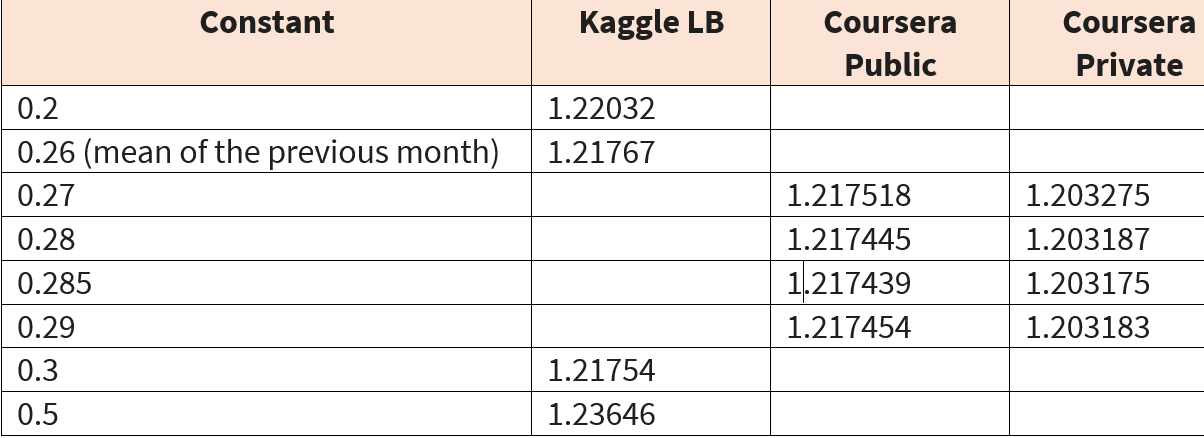

## **6.2 Baseline score:** using previous months count otherwise '0'

* last month, fillna(0), clip(0,20)    : public LB: 1.167778 --private: 1.172726
* last 3 months , fillna(0), clip(0,20): public LB: 1.09979
* last 4 months , fillna(0), clip(0,20): public LB: 1.08401
* last 6 months , fillna(0), clip(0,20): public LB: 1.10126

### **6.2.1 Last month count**

* The following code uses the date_block 33 values as predictions for the next block
* Using Coursera Grader: Your public and private LB scores are: 1.167778 and 1.172726.
* It's an improvement comapred to the 'constant value' but still far from the best LB score @10 Feb 2022: 0.75368

In [119]:
last_month_cnt=train[train['date_block_num']==33].groupby(['shop_id','item_id'])['item_cnt_day'].sum().reset_index()
last_month_cnt.rename(columns={'item_cnt_day':'item_cnt_month'},inplace=True)
df_test=pd.merge(test, last_month_cnt, how="left", on=["shop_id", "item_id"])
df_test['item_cnt_month']=df_test['item_cnt_month'].fillna(0).clip(0,20)
df_test[['ID','item_cnt_month']].to_csv(DIR_OUTPUT + 'submission_previous_month.csv', index=False)

### **6.2.2 Average of the previous months**

In [120]:
nb_months=3
last_month_cnt=train[train['date_block_num']>33-nb_months].groupby(['shop_id','item_id'])['item_cnt_day'].sum().reset_index()
last_month_cnt.rename(columns={'item_cnt_day':'item_cnt_month'},inplace=True)
last_month_cnt['item_cnt_month']=last_month_cnt['item_cnt_month']/nb_months
df_test=pd.merge(test, last_month_cnt, how="left", on=["shop_id", "item_id"])
df_test['item_cnt_month']=df_test['item_cnt_month'].fillna(0).clip(0,20)
df_test[['ID','item_cnt_month']].to_csv(DIR_OUTPUT + 'submission_previous_month.csv', index=False)

## **6.3 Non-Optimized XGBoost run** (Using GPU)

In [116]:
############# Utility Functions to be used to check the score improvement at each step #########
gc.collect()
from xgboost import plot_importance
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
def plot_features(booster, figsize):
    rcParams['figure.figsize'] = 12, 4
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
def print_features(model):
    feat_imp=model.feature_importances_
    imp_df= pd.Series(feat_imp,index=list(X_train.columns))
    print(imp_df.sort_values(ascending=False))

params00={'max_depth': 10, 'eta': 0.01}
params01={'max_depth': 9, 'eta': 0.01, 'min_child_weight': 10,
          'subsample': 0.6, 'colsample_bytree': 0.6, 'alpha': 60,
          'reg_lambda': 10, 'booster': 'gbtree', 'gamma': 0.1, 'grow_policy': 'depthwise'}

def run_XGB_training(params,with_submission=True,with_val_preds=False,with_train_preds=False,show_feat=False,use_file=False,fname=''):
    if (use_file):
        model = pickle.load(open(DIR_JSON+fname, "rb"))
    else:
        model = XGBRegressor (tree_method='gpu_hist' ,seed = 42, n_estimators = 2000,**params)
        model.fit(X_train,Y_train,eval_metric="rmse",eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
            verbose=50, early_stopping_rounds = 20)
        pickle.dump(model, open(DIR_JSON+fname, "wb"))
    Y_test = model.predict(X_test).clip(0, 20) #.round()
    if with_submission:
        submission = pd.DataFrame({"ID": test.index,"item_cnt_month": Y_test })
        submission.to_csv(DIR_OUTPUT+'submission_'+fname.split('.')[0]+'.csv', index=False)
    Y_train_pred = model.predict(X_train).clip(0, 20) if with_train_preds else None
    Y_valid_pred = model.predict(X_valid).clip(0, 20) if with_val_preds else None
    if show_feat: print_features(model)
    return model,Y_train_pred,Y_valid_pred,Y_test

In [117]:
### The non-optimized XGBoost uses max_depth of 10 and a learning_rate of 0.01.
### All other parameters are default
if (START_FROM<3):
    model_fname='xgboost_model_6_3_params00.json'
    model,_,_,_=run_XGB_training(params00,show_feat=True,use_file=USE_SERIALIZED_MODELS,fname=model_fname)
    del model
# Fitting last step: [364]	validation_0-rmse:0.77076	validation_1-rmse:0.80252
# The coursera grader scores are: Public = 0.890974 and 0.890504
# The Features Engineering allowed to go from a baseline score of 1.17 to 0.89. A significant jump.
# The Coursera grade is 10/10.
# If Rounding is added the scores are: 0.908243 and 0.908154

item_cnt_month_lag_1                     0.509657
item_first_sale                          0.066999
item_category_id                         0.035587
item_cnt_month_lag_3                     0.029966
date_item_avg_item_cnt_lag_1             0.025851
date_item_city_avg_item_cnt_lag_1        0.021922
items_pca4                               0.018663
items_pca5                               0.017706
month                                    0.017366
items_pca2                               0.017311
item_cnt_month_lag_2                     0.016493
items_pca0                               0.016336
items_pca3                               0.015762
items_pca1                               0.015225
date_shop_subtype2_avg_item_cnt_lag_1    0.014531
shop_id                                  0.014341
nb_holiday_days                          0.012465
date_shop_avg_item_cnt_lag_1             0.012167
nb_business_days                         0.010020
item_id                                  0.009175


# **7. Leakage Detection**

## 7.1 Checking the correlation 1- between features and 2- between features and Target

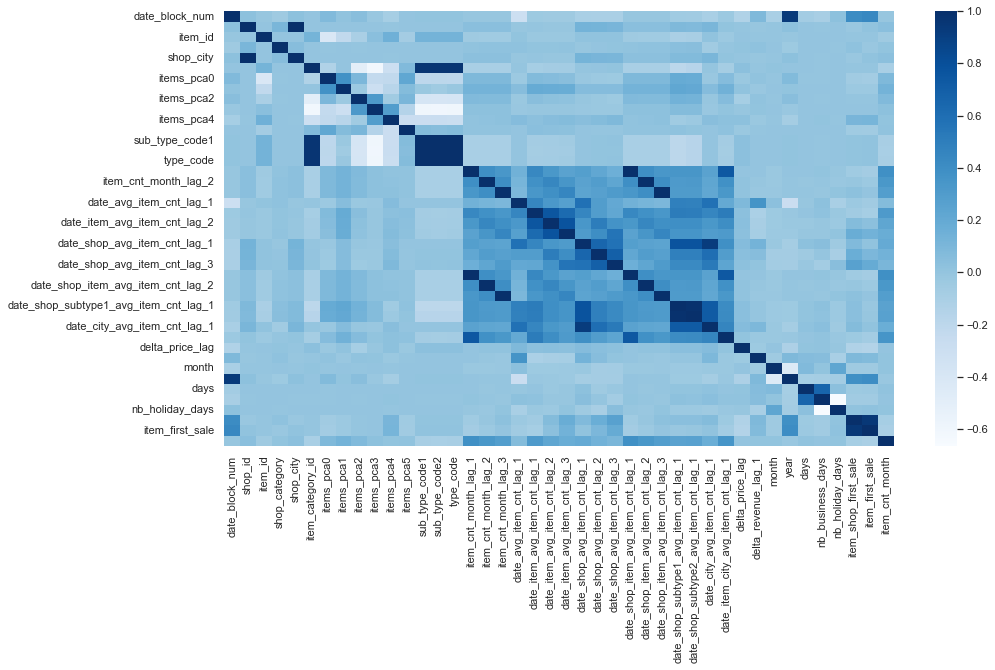

In [118]:
if (START_FROM<3):
    df=pd.concat([X_train,Y_train],axis=1)
    corr = df.corr(method='spearman')
    gc.collect()
    sns.heatmap(corr, cmap="Blues")

In [121]:
if (START_FROM<3):
    corr.to_csv(DIR_OUTPUT+'correlation_before_MeanEncoding.csv')
    # It's better to analyze the matrix in MS Excel
    #print(corr[corr>0.7])

In [122]:
# Very high correlation between the features and the Target indicates a potential Leakage
if (START_FROM<3):
    target_corr=corr['item_cnt_month']
    print(target_corr[target_corr>0.25])
# There are 10 features

item_cnt_month_lag_1                     0.382173
item_cnt_month_lag_2                     0.330680
item_cnt_month_lag_3                     0.289433
date_item_avg_item_cnt_lag_1             0.312828
date_shop_item_avg_item_cnt_lag_1        0.382173
date_shop_item_avg_item_cnt_lag_2        0.330680
date_shop_item_avg_item_cnt_lag_3        0.289433
date_shop_subtype1_avg_item_cnt_lag_1    0.254897
date_shop_subtype2_avg_item_cnt_lag_1    0.258667
date_item_city_avg_item_cnt_lag_1        0.352103
item_cnt_month                           1.000000
Name: item_cnt_month, dtype: float64


## 7.2 Using Hierarchical Clustering to eliminate redundant features

In [123]:
if (START_FROM<3):
    import scipy
    from scipy.cluster import hierarchy as hc
    def find_FeaturesToKeep(df,threshold):
        corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
        corr_condensed = hc.distance.squareform(1-corr)
        z = hc.linkage(corr_condensed, method='average')
        T = hc.fcluster(z, threshold, criterion='distance')
        #L, M = hc.leaders(z, T)
        _,ix=np.unique(T,return_index=True)
        return df.columns[ix]

    features_to_keep=list(find_FeaturesToKeep(X_train,0.03))
    print('#Features to be removed= ',X_train.shape[1]-len(features_to_keep),'. Total #Features: ',X_train.shape[1])
    for a in aggregation_cols:
        if (~pd.Series(features_to_keep).isin([a]).any()):
            features_to_keep.append(a)
            print('one of the essentials added. It has strong correclation with some features: ',a)
    features_to_drop2=set(X_train.columns)-set(features_to_keep)
    gc.collect()
    #print('Features to be removed from Correlation= ',features_to_drop1)
    print('Features to be removed from HC= ',features_to_drop2)
    ## For HC threshold =0.03 ==> {'date_shop_item_avg_item_cnt_lag_2', 'type_code', 'date_shop_subtype2_avg_item_cnt_lag_1',
    ##'date_shop_item_avg_item_cnt_lag_3', 'shop_city', 'date_shop_item_avg_item_cnt_lag_1', 'sub_type_code2'}

#Features to be removed=  7 . Total #Features:  41
Features to be removed from HC=  {'shop_city', 'date_shop_item_avg_item_cnt_lag_2', 'date_shop_item_avg_item_cnt_lag_3', 'type_code', 'sub_type_code2', 'date_shop_item_avg_item_cnt_lag_1', 'date_shop_subtype2_avg_item_cnt_lag_1'}


# **8. Mean/Target Encoding**

In [124]:
# Using Leave one out coding for categorical features + adding noise + Cross-validation
if (START_FROM<3):
    cat_cols=['item_category_id','shop_category' ,'shop_city','sub_type_code1','sub_type_code2','type_code']
    #from category_encoders.target_encoder import TargetEncoder #
    from category_encoders.leave_one_out import LeaveOneOutEncoder
    from category_encoders.wrapper import NestedCVWrapper
    t_enc=LeaveOneOutEncoder(cols=cat_cols,sigma=0)
    n_enc=NestedCVWrapper(t_enc, cv=5, shuffle=True, random_state=999)
    X_train=n_enc.fit_transform(X_train,Y_train)
    X_valid=n_enc.transform(X_valid)
    X_test=n_enc.transform(X_test)
    for col in cat_cols:
        X_train[col]=X_train[col].astype(np.float16)
        X_valid[col]=X_valid[col].astype(np.float16)
        X_test[col]=X_test[col].astype(np.float16)
    gc.collect()
    print(X_train[cat_cols])

         item_category_id  shop_category  shop_city  sub_type_code1  \
0                0.703613       0.317383   0.131592        0.648438   
1                1.125977       0.317383   0.133301        0.648926   
2                0.676758       0.317139   0.132324        0.647949   
3                0.246338       0.317383   0.133301        0.217163   
4                0.177856       0.317383   0.131592        0.216919   
...                   ...            ...        ...             ...   
8792875          0.246704       0.317139   0.200073        0.217163   
8792876          0.246826       0.317627   0.199951        0.217407   
8792877          0.178223       0.317383   0.201904        0.217163   
8792878          0.157715       0.317383   0.201294        0.129272   
8792879          0.199951       0.317383   0.201294        0.129272   

         sub_type_code2  type_code  
0              0.768555   0.640137  
1              0.625488   0.640625  
2              0.635742   0.639160  

In [125]:
if (START_FROM<3):
    pickle.dump( (X_train,Y_train,X_valid,Y_valid,X_test), open( DIR_OUTPUT+"training_datasets_MeanEnc_sigma0_10Feb.pkl", "wb" ) )
    print('Until after_mean_encoding Executed!')
else:
    print('Jumped after_mean_encoding!')

Until after_mean_encoding Executed!


In [126]:
# Running again XGBoost with the same previous model
if (START_FROM<3):
    model_fname='xgboost_model_8_0.json'
    model,_,_,_=run_XGB_training(params00,show_feat=True,use_file=USE_SERIALIZED_MODELS,fname=model_fname)
    del model
# Without Mean Encoding : Public = 0.890974 and Private=0.890504
#############  Using LeaveOneOut+CV Encoder with Sigma=0.0#######################
# Fitting last step:  [350]	validation_0-rmse:0.76802	validation_1-rmse:0.78811
# With Mean Encoding :    Public =0.881963 and Private =0.885066

item_cnt_month_lag_1                     0.521174
item_first_sale                          0.063298
item_category_id                         0.040935
item_cnt_month_lag_3                     0.028491
date_item_avg_item_cnt_lag_1             0.025376
items_pca3                               0.020500
items_pca2                               0.019126
date_item_city_avg_item_cnt_lag_1        0.018476
month                                    0.016633
item_cnt_month_lag_2                     0.016534
shop_city                                0.015628
date_shop_subtype2_avg_item_cnt_lag_1    0.013748
items_pca5                               0.013270
items_pca4                               0.012595
items_pca0                               0.012518
date_shop_avg_item_cnt_lag_1             0.012283
items_pca1                               0.011447
item_id                                  0.009834
nb_holiday_days                          0.009730
sub_type_code2                           0.009143


In [127]:
if (START_FROM==3):
    X_train,Y_train,X_valid,Y_valid,X_test = pickle.load(open( DIR_OUTPUT+'training_datasets_MeanEnc_sigma0_10Feb.pkl', "rb" ) )
    print('Train/Valid/Test Data Loaded after_mean_encoding!')

# **9. Dropping Redundant and non-important Features**

***Iterate between Feature Importance, Correlation and HC as long as the Score is improving***

In [128]:
col_to_drop=[ 'date_shop_item_avg_item_cnt_lag_3', 'date_shop_item_avg_item_cnt_lag_1',
             'date_shop_item_avg_item_cnt_lag_2', 'year',
             #'sub_type_code1','date_shop_subtype1_avg_item_cnt_lag_1', 'type_code','nb_holiday_days'
            ]
#'date_shop_avg_item_cnt_lag_3']#,'nb_holiday_days']
#'sub_type_code2', 'type_code','date_shop_subtype2_avg_item_cnt_lag_1',
def drop_cols(cols):
    X_train.drop(cols,axis=1,inplace=True)
    X_valid.drop(cols,axis=1,inplace=True)
    X_test.drop(cols,axis=1,inplace=True)
print('Shape before: ',X_train.shape)
drop_cols(col_to_drop)
gc.collect()
print('Shape afer: ',X_train.shape)

Shape before:  (8792880, 41)
Shape afer:  (8792880, 37)


In [129]:
# Running again XGBoost with the same previous model to check the impact of Dropping the above features
model_fname='xgboost_model_9_0.json'
model,_,_,_=run_XGB_training(params00,show_feat=True,use_file=USE_SERIALIZED_MODELS,fname=model_fname)
del model
#### Public/Private = 0.881963 and 0.885066

item_cnt_month_lag_1                     0.521174
item_first_sale                          0.063298
item_category_id                         0.040935
item_cnt_month_lag_3                     0.028491
date_item_avg_item_cnt_lag_1             0.025376
items_pca3                               0.020500
items_pca2                               0.019126
date_item_city_avg_item_cnt_lag_1        0.018476
month                                    0.016633
item_cnt_month_lag_2                     0.016534
shop_city                                0.015628
date_shop_subtype2_avg_item_cnt_lag_1    0.013748
items_pca5                               0.013270
items_pca4                               0.012595
items_pca0                               0.012518
date_shop_avg_item_cnt_lag_1             0.012283
items_pca1                               0.011447
item_id                                  0.009834
nb_holiday_days                          0.009730
sub_type_code2                           0.009143


# **10. Algorithm Optimization**

* I used OPTUNA to finetune the hyperparameters for XGBoost, CatBoost, LGBM and Fastai Tabular Neural Network. 

In [130]:
# These lists will be used for Ensembling and Stacking
test_preds=[]
val_preds=[]

## **10.1 XGBoost**

In [131]:
gc.collect()

def execute_XGB():
    params43={'max_depth': 11, 'eta': 0.0814409011722099, 'min_child_weight': 36.28309377320559,
              'subsample': 0.5871817395511052, 'colsample_bytree': 0.8278290725391293, 'alpha': 47.73774236898744,
              'reg_lambda': 73.30489520665812, 'gamma': 3.866115369278931e-08, 'grow_policy': 'depthwise'}

    xgb_config_list=[(params43,'xgboost_model_10_1_params43.json'), ]
    xgb_config_num=0
    model,_,Y_val_preds,Y_test=run_XGB_training(xgb_config_list[xgb_config_num][0],with_submission=True,with_val_preds=True,
                with_train_preds=False,show_feat=False,use_file=USE_SERIALIZED_MODELS,fname=xgb_config_list[xgb_config_num][1])
    del model

    test_preds.append(Y_test)
    val_preds.append(Y_val_preds)
    
execute_XGB()

## **10.2 LGBM**

In [132]:
import lightgbm as lgb
def get_LGBM_preds(use_file=False,fname=''):

    lgb_train = lgb.Dataset(X_train, Y_train, free_raw_data=False)
    lgb_val = lgb.Dataset(X_valid, Y_valid, reference=lgb_train, free_raw_data=False)
       
    lgbm_params_01 ={'device':'gpu','objective': 'mse','metric': 'rmse','verbosity': -1,'seed': 1,
        'max_depth': 13, 'num_leaves': 741, 'learning_rate': 0.003, 'feature_fraction': 0.6887144607407563, #0.013722823689461533
                     'bagging_fraction': 0.6863818533659629, 'bagging_freq': 1, 'min_data_in_leaf': 200, 'min_sum_hessian_in_leaf': 46,
                     'force_row_wise': True, 'reg_alpha': 106.16746153811141, 'reg_lambda': 1.0363719834284624, 'min_gain_to_split': 9.885189405702652, 'max_bin': 170}
    if (use_file):
        model = pickle.load(open(DIR_JSON+fname, "rb"))
    else:          
        model = lgb.train(lgbm_params_01, lgb_train, num_boost_round = 5000,valid_names=['train', 'valid'],  
                          valid_sets=[lgb_train, lgb_val],
                     callbacks=[lgb.log_evaluation(period=100, show_stdv=False),
                      lgb.early_stopping(30, first_metric_only=True, verbose=True)])
        pickle.dump(model, open(fname, "wb"))
    
    test_preds=model.predict(X_test)
    val_preds=model.predict(X_valid)  

    return test_preds,val_preds

def execute_LGBM():
    model_fname='lgbm_model_10_2.json'
    # No categorical variables declared !! may be for the future
    Y_test,v_preds=get_LGBM_preds(USE_SERIALIZED_MODELS,fname=model_fname)
    submission = pd.DataFrame({"ID": test.index,"item_cnt_month": Y_test })
    submission.to_csv(DIR_OUTPUT+'submission_'+model_fname.split('.')[0]+'.csv', index=False)

    test_preds.append(Y_test)
    val_preds.append(v_preds)
    gc.collect()

    
execute_LGBM()

## **10.3 Fastai Tabular (NN)**

## **10.4 Random Forest** (using XGB GPU Random Forest)

In [133]:
from xgboost import XGBRFRegressor
#X_train,Y_train,X_valid,Y_valid,X_test = pickle.load(open( PATH+"training_datasets_MeanEnc_sigma0_10Feb.pkl", "rb" ) )
#drop_cols(col_to_drop)
#gc.collect()

In [136]:
def excute_RF():
    model_fname='RF_model_10_4.json'
    
    if (USE_SERIALIZED_MODELS):
        model = pickle.load(open(DIR_JSON+model_fname, "rb"))
    else:  
        model = XGBRFRegressor(tree_method='gpu_hist' ,seed = 42, n_estimators = 200,max_depth =13,
                           colsample_bytree=0.8,subsample=0.8,colsample_bynode=0.4,reg_alpha=10)
        model.fit(X_train,Y_train,eval_metric="rmse",eval_set=[(X_train, Y_train), (X_valid, Y_valid)],verbose=50)
        pickle.dump(model, open(DIR_JSON+model_fname, "wb"))
    
    Y_valid_pred = model.predict(X_valid).clip(0, 20)
    Y_test = model.predict(X_test).clip(0, 20)
    submission = pd.DataFrame({"ID": test.index,"item_cnt_month": Y_test })
    submission.to_csv(DIR_OUTPUT+'submission_'+model_fname.split('.')[0]+'.csv', index=False)
    test_preds.append(Y_test)
    val_preds.append(Y_valid_pred)
excute_RF()    
gc.collect()

60

## **10.5 CatBoost**

* It uses its own Mean Encoding for Categorical variables.
* We load the Train/Valid/Test Datasets before the Mean Encoding

In [138]:
PATH_cb = '' if START_FROM<2 else PATH
X_train,Y_train,X_valid,Y_valid,X_test = pickle.load(open( DIR_OUTPUT+"training_datasets_00_10Feb.pkl", "rb" ) )
drop_cols(col_to_drop)
gc.collect()
def execute_catBoost():
    model_fname='catboost_model_10_5.json'
    cat_cols=['shop_category' ,'shop_city','item_category_id','sub_type_code2','sub_type_code1','type_code']
    params_cb_00={'learning_rate': 0.01, 'depth': 14, 'min_data_in_leaf': 1000, 'l2_leaf_reg': 0.001, 'bagging_temperature': 0.7, 'random_strength': 0.3}
    params_cb_01={'learning_rate': 0.01, 'depth': 11, 'min_data_in_leaf': 481, 'l2_leaf_reg': 0.1, 'bagging_temperature': 0.3, 'random_strength': 0.22}
    import catboost as cb

    if (USE_SERIALIZED_MODELS):
            model = pickle.load(open(DIR_JSON+model_fname, "rb"))
    else:          
        model = cb.CatBoostRegressor(iterations=1000,loss_function='RMSE', eval_metric='RMSE',random_seed=23,od_wait=100, 
             od_type='Iter', metric_period=100,task_type='GPU',devices='0:1',**params_cb_00)
        model.fit(X_train, Y_train,cat_features=cat_cols,eval_set=[(X_valid, Y_valid)],use_best_model=True,early_stopping_rounds = 20)
        pickle.dump(model, open(DIR_JSON+model_fname, "wb"))

    Y_valid_pred = model.predict(X_valid).clip(0, 20)
    Y_test = model.predict(X_test).clip(0, 20)
    submission = pd.DataFrame({"ID": test.index,"item_cnt_month": Y_test })
    submission.to_csv(DIR_OUTPUT+'submission_'+model_fname.split('.')[0]+'.csv', index=False)
    gc.collect()
    test_preds.append(Y_test)
    val_preds.append(Y_valid_pred)

execute_catBoost()

# **11. Ensembling and Stacking**

In [139]:
import copy
test_preds_orig=copy.deepcopy(test_preds)
pickle.dump((val_preds,test_preds), open(DIR_OUTPUT+'val_test_preds.pkl', "wb"))

In [140]:
ENSEMBLING_METHOD=2

In [141]:
#val_preds,test_preds=pickle.load(open("val_test_preds.pkl", "rb" ) )
len(val_preds),len(test_preds)

(4, 4)

## **11.1 Ensembling**

In [142]:
from scipy.optimize import differential_evolution
from scipy.optimize import NonlinearConstraint

n_estimations=len(val_preds)
def constr_f(x):
    return np.sum(x)
def hess_zero(y,z): return [0]*n_estimations
def objective(x):
  weighted_sum=np.zeros_like(val_preds[0])
  for i in range(n_estimations):
      weighted_sum+=(val_preds[i]*x[i])
  return rmse(weighted_sum,Y_valid)

def get_ensemble_weight():
    # the sum of elements in x must be 1
    nlc = NonlinearConstraint(constr_f, 1, 1,hess=hess_zero)# lower bound, upper bound
    bounds = [[0, 1]]*n_estimations
    result = differential_evolution(objective, bounds,constraints=nlc)
    return result['x']

def ensemble_preds():
    weights=get_ensemble_weight()
    test_preds_final=np.average(test_preds,axis=0,weights=weights)#np.round(
    print('# Estimators: ',len(test_preds))
    print('Enseble Weights: ',weights,'. Sum= ',weights.sum())
    return [test_preds_final]

if ENSEMBLING_METHOD==1: 
    test_preds=ensemble_preds()

## **11.2 Stacking**

In [143]:
from sklearn.linear_model import LinearRegression
meta_model = LinearRegression()

def stacking_preds(meta_model,v_preds,t_preds,y_val):
    stacked_predictions=np.column_stack(v_preds)
    stacked_test_predictions=np.column_stack(t_preds)
    
    #fit meta model on stacked predictions
    meta_model.fit(stacked_predictions,y_val)
    print('RMSE =',rmse(meta_model.predict(stacked_predictions).clip(0, 20),y_val))
    return [meta_model.predict(stacked_test_predictions).clip(0, 20)]

if ENSEMBLING_METHOD==2:
    test_preds=stacking_preds(meta_model,val_preds,test_preds,Y_valid)

RMSE = 0.7725920606496864


# **12. Inference and Submission**

In [144]:
Y_test=np.average(test_preds,axis=0)
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv(DIR_OUTPUT+'submission_'+str(ENSEMBLING_METHOD)+'.csv', index=False)
submission.to_csv(DIR_OUTPUT+'submission.csv', index=False)
